# The Battle of Neighborhoods
## Coursera's "Applied Data Science Capstone" Project - Weeks 4 and 5 Assignment

**Student:** Michael Onishi <br>
**Date:** June 2020

https://www.coursera.org/learn/applied-data-science-capstone

## Introduction

This is the final assignment from the Coursera's "Applied Data Science Capstone" course. In this project we are required to: 
> come up with an idea to leverage the Foursquare location data to explore or compare neighborhoods or cities of your choice or to come up with a problem that you can use the Foursquare location data to solve.

For this project, I will build a model that recommends neighborhoods of San Diego/California to someone based on his/her interest. So it may be used by someone looking for a place to live in San Diego or just going there for tourism.

The user will give a weight to each of the following categories (all of them are top level venue categories from Foursquare):

 * Arts & Entertainment
 * College & University
 * Food
 * Nightlife Spot
 * Outdoors & Recreation
 * Shop & Service
 
Based on this profile, the system will recommend neighborhoods that get the best scores.

Although I am Brazilian, I chose San Diego because it appears to be a city well covered in Foursquare and I fell in love with it when I went there some years ago.

## Data

To get the neighborhood location data, I will use data from San Diego Open Data Portal: https://data.sandiego.gov/datasets/pd-neighborhoods/ .

As mencioned there, _"These boundaries are for law enforcement only and do not represent legal neighborhood or community boundaries."_ But I think it represents pretty well the official neighborhoods, so I will use it in this project.

Then I will get venues information for every neighborhood using the Foursquare API. The most important data will be the top level category for each venue.

### Retrieving neighborhood data

In [1]:
import json # library to handle JSON files
import numpy as np # library to handle data in a vectorized manner
import pandas as pd

In [2]:
!curl http://seshat.datasd.org/sde/pd/pd_neighborhoods_datasd.geojson -o sandiego_data.json
print('Data downloaded!')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5861k  100 5861k    0     0  2471k      0  0:00:02  0:00:02 --:--:-- 2471k
Data downloaded!


In [3]:
with open('sandiego_data.json') as json_data:
    sandiego_data = json.load(json_data)

This file is in geojson format. So I will have to transform the polygons points to only one coordinate representing the neighborhood location.

In [4]:
from collections.abc import Iterable

def flatten(l):
    """Used to flatten the latitude and latitude arrays"""
    for el in l:
        if isinstance(el, Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el

neighborhoods_data = sandiego_data['features']
names = []
latitudes = []
longitudes = []
for data in neighborhoods_data:
    names.append(data['properties']['name'])
    # turning all the coordinates into a flat list
    all_coordinates = list(flatten(data['geometry']['coordinates']))
    
    # then transform them into a list of tuples of latitudes and longitudes
    all_coordinates = np.reshape(all_coordinates, (-1,2))
    
    # using the mean of all polygon points to make only one position for the neighbor
    coordinates = np.mean(all_coordinates, axis=0)
    latitudes.append(coordinates[1])
    longitudes.append(coordinates[0])

Let's transform these lists into a pandas Dataframe.

In [5]:
df = pd.DataFrame(zip(names, latitudes, longitudes), columns =['Neighborhood', 'Latitude', 'Longitude'])

In [6]:
print(df.shape)
df.head()

(124, 3)


,Neighborhood,Latitude,Longitude
0,MIRAMAR RANCH NORTH,32.925050,-117.098017
1,TORREY HIGHLANDS,32.969518,-117.149431
2,MISSION BAY,32.776936,-117.221800
3,NORTH CITY,32.970820,-117.217243
4,LOMA PORTAL,32.745151,-117.221147


#### Let's plot in a map to see if it appears correct

In [7]:
import folium

# create map of San Diego using latitude and longitude values
sandiego_latitude = 32.715736
sandiego_longitude = -117.161087
map_sandiego = folium.Map(location=[sandiego_latitude, sandiego_longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = folium.Popup(neighborhood, parse_html=True)
    folium.CircleMarker(
        location=(lat, lng),
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sandiego)
    
map_sandiego

### Retrieving venue data from the neighborhoods

#### Define Foursquare Credentials and Version

In [8]:
import yaml
import requests

## retrieving the Foursquare API credentials
with open("config.yml", 'r') as ymlfile:
    cfg = yaml.safe_load(ymlfile)

CLIENT_ID = cfg['foursquare_api_credentials']['CLIENT_ID'] # your Foursquare ID
CLIENT_SECRET = cfg['foursquare_api_credentials']['CLIENT_SECRET'] # your Foursquare Secret
VERSION = '20200618' # Foursquare API version

In [9]:
def getCategories():
    """As defined here: https://developer.foursquare.com/docs/api-reference/venues/categories/"""
    
    # create the API request URL
    url = f'https://api.foursquare.com/v2/venues/categories?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}'
    
    # make the GET request
    results = requests.get(url).json()["response"]['categories']
    return results

def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    """Using this API: https://developer.foursquare.com/docs/api-reference/venues/explore/"""
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Filtering the target categories

In [10]:
categories = getCategories()

In [11]:
target_categories_names = ['Arts & Entertainment',
                           'College & University',
                           'Food',
                           'Nightlife Spot',
                           'Outdoors & Recreation',
                           'Shop & Service']

target_categories = [c for c in categories if c['name'] in target_categories_names]

In [12]:
print(f'There are {len(target_categories)} selected categories')
target_categories[0].keys()

There are 6 selected categories


dict_keys(['id', 'name', 'pluralName', 'shortName', 'icon', 'categories'])

#### Getting the venues for the neighborhoods

In [13]:
%%time

sandiego_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

CPU times: user 3.01 s, sys: 165 ms, total: 3.17 s
Wall time: 2min 8s


In [14]:
sandiego_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,TORREY HIGHLANDS,32.969518,-117.149431,Sheraton,32.966311,-117.149272,Hotel
1,TORREY HIGHLANDS,32.969518,-117.149431,Westview Football Stadium,32.966387,-117.149772,Football Stadium
2,TORREY HIGHLANDS,32.969518,-117.149431,Abl Photography,32.967310,-117.152946,Photography Studio
3,MISSION BAY,32.776936,-117.221800,Fiesta Island Dog Park,32.774062,-117.222682,Dog Run
4,MISSION BAY,32.776936,-117.221800,Over The Line,32.777566,-117.221148,Athletics & Sports
...,...,...,...,...,...,...,...
1700,SABRE SPRINGS,32.946708,-117.091497,Alvaros,32.947653,-117.096305,Mexican Restaurant
1701,SABRE SPRINGS,32.946708,-117.091497,Saber Springs Trail,32.945240,-117.090650,Trail
1702,SABRE SPRINGS,32.946708,-117.091497,Sabre Springs Marketplace,32.948147,-117.096313,Shopping Mall
1703,SABRE SPRINGS,32.946708,-117.091497,Carmel Mountain Ranch Community Park,32.948190,-117.096367,Park


#### Let's create a new column with the parent category

In [15]:
def flatten_category_descendants(l):
    """Used to flatten the list of descendants of a category"""
    for el in l['categories']:
        yield from flatten_category_descendants(el)
        yield el['name']

In [16]:
parent_category_map = {}
for cat in target_categories:
    # for the top most category, let's consider it parent of itself
    parent_category_map[cat['name']] = cat['name']
    
    for desc in flatten_category_descendants(cat):
        parent_category_map[desc] = cat['name']

In [17]:
sandiego_venues['Parent Category'] = sandiego_venues['Venue Category'].map(parent_category_map)

In [18]:
sandiego_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Parent Category
0,TORREY HIGHLANDS,32.969518,-117.149431,Sheraton,32.966311,-117.149272,Hotel,NaN
1,TORREY HIGHLANDS,32.969518,-117.149431,Westview Football Stadium,32.966387,-117.149772,Football Stadium,Arts & Entertainment
2,TORREY HIGHLANDS,32.969518,-117.149431,Abl Photography,32.967310,-117.152946,Photography Studio,Shop & Service
3,MISSION BAY,32.776936,-117.221800,Fiesta Island Dog Park,32.774062,-117.222682,Dog Run,Outdoors & Recreation
4,MISSION BAY,32.776936,-117.221800,Over The Line,32.777566,-117.221148,Athletics & Sports,Outdoors & Recreation


Need to remove categories out of our target set

In [19]:
sandiego_venues.dropna(subset = ['Parent Category'], inplace=True)

In [20]:
print(len(sandiego_venues))
sandiego_venues.head()

1583


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Parent Category
1,TORREY HIGHLANDS,32.969518,-117.149431,Westview Football Stadium,32.966387,-117.149772,Football Stadium,Arts & Entertainment
2,TORREY HIGHLANDS,32.969518,-117.149431,Abl Photography,32.967310,-117.152946,Photography Studio,Shop & Service
3,MISSION BAY,32.776936,-117.221800,Fiesta Island Dog Park,32.774062,-117.222682,Dog Run,Outdoors & Recreation
4,MISSION BAY,32.776936,-117.221800,Over The Line,32.777566,-117.221148,Athletics & Sports,Outdoors & Recreation
5,LOMA PORTAL,32.745151,-117.221147,Jack in the box,32.747826,-117.218484,Fast Food Restaurant,Food


#### Now we will aggregate data for each neighborhood

In [21]:
final_df = pd.crosstab(sandiego_venues['Neighborhood'], sandiego_venues['Parent Category'])

In [22]:
final_df

Parent Category,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Shop & Service
Neighborhood,,,,,,
ADAMS NORTH,1,0,1,0,1,1
ALLIED GARDENS,0,0,0,1,0,0
ALTA VISTA,0,0,0,0,2,0
AZALEA/HOLLYWOOD PARK,0,0,1,0,1,2
BALBOA PARK,9,0,4,0,9,0
...,...,...,...,...,...,...
TORREY PINES,1,1,15,0,0,2
TORREY PRESERVE,0,0,3,0,1,0
UNIVERSITY CITY,0,0,1,1,2,1


In [23]:
final_df.to_csv('final_grouped.csv')

#### Let's show some of the distributions.

In [24]:
%matplotlib inline

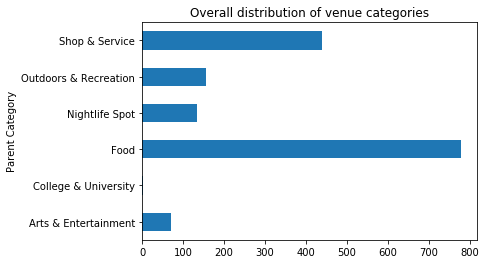

In [43]:
final_df.sum().plot.barh(title='Overall distribution of venue categories')

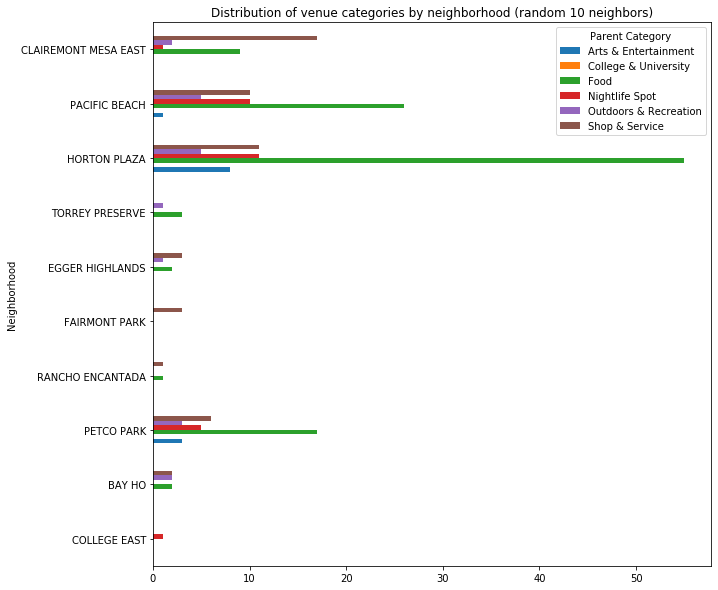

In [49]:
final_df.sample(n=10).plot.barh(title='Distribution of venue categories by neighborhood (random 10 neighborhoods)', figsize=(10,10))

#### Time to know the customer's preferences by the selected categories

Let's create 3 profiles to know how the recommendation engine will perform.

##### Profile 1: Young single men looking for fun.

<pre>
Arts & Entertainment = 6
College & University = 4
Food = 2
Nightlife Spot = 10
Outdoors & Recreation = 5
Shop & Service = 2
</pre>

#####  Profile 2: A stable mid-aged couple looking for living in the city.
<pre>
Arts & Entertainment = 7
College & University = 0
Food = 6
Nightlife Spot = 2
Outdoors & Recreation = 5
Shop & Service = 6
</pre>

##### Profile 3: An retired woman looking for peace
<pre>
Arts & Entertainment = 7
College & University = -1
Food = 5
Nightlife Spot = -5
Outdoors & Recreation = 10
Shop & Service = 5
</pre>

In [60]:
profiles = np.array([[6,4,2,10,5,2],
                     [7,0,6,2,5,6],
                     [7,-1,5,-5,10,5]])

#### Calculating scores

Using cosine similarity measure to make sure the disparity on the number of venues do not interfere in the score. It also makes it possible to the user to choose any range of weights for the categories.

In [54]:
from sklearn.metrics.pairwise import cosine_similarity

In [67]:
df_similarity = pd.DataFrame(cosine_similarity(final_df, profiles), index=final_df.index, columns=['Profile 1', 'Profile 2', 'Profile 3'])

#### Finally the top 5 neighborhood recommendations for each profile!

In [76]:
df_similarity['Profile 1'].sort_values(ascending=False)[:5]

Neighborhood
SERRA MESA         0.778078
ALLIED GARDENS     0.735215
COLLEGE EAST       0.735215
UNIVERSITY CITY    0.666924
SOUTH PARK         0.660330
Name: Profile 1, dtype: float64

In [77]:
df_similarity['Profile 2'].sort_values(ascending=False)[:5]

Neighborhood
ADAMS NORTH    0.979796
LINDA VISTA    0.895669
SAN YSIDRO     0.835573
QUALCOMM       0.833333
CORTEZ         0.818165
Name: Profile 2, dtype: float64

In [78]:
df_similarity['Profile 3'].sort_values(ascending=False)[:5]

Neighborhood
ADAMS NORTH      0.900000
SAN CARLOS       0.870930
BALBOA PARK      0.864460
LOGAN HEIGHTS    0.812362
OCEAN CREST      0.801388
Name: Profile 3, dtype: float64

#### The bottom 5 neighborhood for each profile (please avoid them)!

In [80]:
df_similarity['Profile 1'].sort_values()[:5]

Neighborhood
JAMACHA LOMITA    0.147043
EMERALD HILLS     0.147043
SKYLINE           0.147043
TALMADGE          0.147043
PARADISE HILLS    0.147043
Name: Profile 1, dtype: float64

In [81]:
df_similarity['Profile 2'].sort_values()[:5]

Neighborhood
ALLIED GARDENS    0.163299
COLLEGE EAST      0.163299
ROLANDO           0.408248
LAKE MURRAY       0.408248
NESTOR            0.408248
Name: Profile 2, dtype: float64

In [82]:
df_similarity['Profile 3'].sort_values()[:5]

Neighborhood
COLLEGE EAST      -0.333333
ALLIED GARDENS    -0.333333
MIDWAY DISTRICT    0.320750
NORMAL HEIGHTS     0.329287
EMERALD HILLS      0.333333
Name: Profile 3, dtype: float64

## The Results, Discussion and Conclusion sections are in the [final report](final_report.md)